# TGA余额与流动性注入

TGA（Treasury General Account，财政部一般账号），美国政府（财政部）在美联储的存款账号。TGA余额的变化通常被视为美国政府对市场流动性的影响。TGA余额的减少意味着美国政府向市场注入流动性，而TGA余额的增加则意味着从市场回收流动性。

**数据来源**

- [财政部官网](https://fiscaldata.treasury.gov/datasets/daily-treasury-statement/operating-cash-balance)
- [MacroMicro](https://en.macromicro.me/collections/9/us-market-relative/34339/us-treasury-general-account)

**Operating Cash Balance**

- 财政部提供了多个数据集来记录资金使用情况，其中`Operating Cash Balance`数据集记录了美国财政部每日的一般账号余额，单位为百万美元。
- 数据集包含了从2005年1月3日至今的数据。
- 数据集包含一个字段`account_type`，在不同的时间段用不同的账户来表示账户余额，详情如下：
    - 2005年至2021年9月30号：`account_type='Federal Reserve Account'`表示账户余额
    - 2021年10月1号至2022年4月15号：`account_type='Treasury General Account (TGA)'`表示账户余额
    - 2022年4月18号至今：`account_type='Treasury General Account (TGA) Closing Balance'`表示账户余额

In [1]:
import datetime as dt

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from indicators import lowpass_filter

## 下载TGA余额

In [24]:
def fetch_operating_cash_balance(
    start_date: dt.datetime = None, end_date: dt.datetime = None
) -> pd.DataFrame:
    """Fetch operating cash balance table of TGA from the Treasury API.

    Args:
        start_date (datetime): start date of the data to fetch
        end_date (datetime): end date of the data to fetch

    Returns:
        DataFrame: operating cash balance table
    """
    if end_date is None:
        end_date = dt.datetime.today()
    if start_date is None:
        start_date = end_date - dt.timedelta(days=365)

    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    page_number = 1
    page_size = 1000  # max size is 10000

    url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/dts/operating_cash_balance"
    params = {
        "fields": "record_date,account_type,open_today_bal,close_today_bal",
        "filter": f"record_date:gte:{start_date_str},record_date:lte:{end_date_str}",
        "sort": "record_date",
        "format": "json",
        "page[number]": page_number,
        "page[size]": page_size,
    }

    all_data = []

    while True:
        try:
            params.update({"page[number]": page_number})
            resp = requests.get(url, params=params)
            resp.raise_for_status()
        except requests.exceptions.HTTPError as e:
            print(e)
            break
        else:
            resp_json = resp.json()
            data = resp_json["data"]  # list of rows
            count = resp_json["meta"]["count"]  # number of rows returned
            if not data:  # no rows returned
                break
            all_data.extend(data)
            if count < page_size:  # last page
                break
            page_number += 1

    return pd.DataFrame.from_records(all_data)


def extract_balance(df: pd.DataFrame) -> pd.DataFrame:
    """Extract balance data from the operating cash balance table.

    Args:
        df (DataFrame): operating cash balance table

    Returns:
        DataFrame: balance data
    """
    # account_type == 'Federal Reserve Account'
    balance_1 = (
        df.query("account_type == 'Federal Reserve Account'")
        .loc[:, ["record_date", "close_today_bal"]]
        .rename(columns={"record_date": "date", "close_today_bal": "balance"})
    )

    # account_type == 'Treasury General Account'
    balance_2 = (
        df.query("account_type == 'Treasury General Account (TGA)'")
        .loc[:, ["record_date", "close_today_bal"]]
        .rename(columns={"record_date": "date", "close_today_bal": "balance"})
    )

    # account_type == 'Treasury General Account (TGA) Closing Balance'
    balance_3 = (
        df.query("account_type == 'Treasury General Account (TGA) Closing Balance'")
        .loc[:, ["record_date", "open_today_bal"]]
        .rename(columns={"record_date": "date", "open_today_bal": "balance"})
    )

    joined_balance = pd.concat(
        [balance_1, balance_2, balance_3], axis=0, ignore_index=True
    )
    joined_balance = joined_balance.astype({"balance": np.float64})
    joined_balance.set_index("date", inplace=True)

    return joined_balance

In [25]:
start_date = dt.datetime(2005, 1, 1)
end_date = dt.datetime(2025, 1, 31)

res = fetch_operating_cash_balance(start_date, end_date)
balance = extract_balance(res)

In [28]:
balance.tail()

,balance
date,
2025-01-16,677188.0
2025-01-17,673357.0
2025-01-21,704874.0
2025-01-22,665485.0
2025-01-23,760043.0


In [29]:
balance.to_csv("../data/tga_balance.csv", index=True)

<Axes: xlabel='date'>

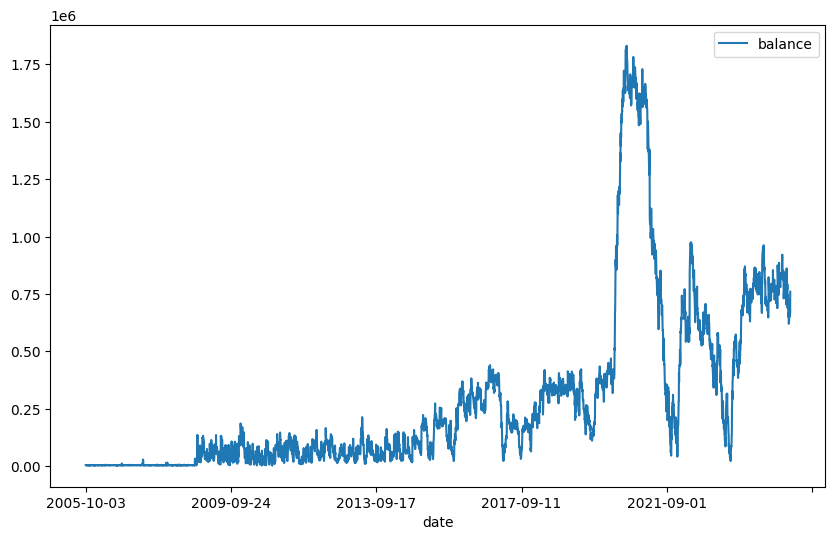

In [31]:
balance.plot(figsize=(10, 6))

In [2]:
balance = pd.read_csv("../data/tga_balance.csv", index_col="date", parse_dates=True)
print(balance.tail())

btc = pd.read_csv("../data/yahoo/Bitcoin.csv", index_col="Date", parse_dates=True)
print(btc.tail())

             balance
date                
2025-01-16  677188.0
2025-01-17  673357.0
2025-01-21  704874.0
2025-01-22  665485.0
2025-01-23  760043.0
                     Open           High            Low          Close  \
Date                                                                     
2025-01-21  102052.578125  107180.921875  100103.953125  106146.265625   
2025-01-22  106136.382812  106294.343750  103360.265625  103653.070312   
2025-01-23  103657.671875  106820.328125  101257.804688  103960.171875   
2025-01-24  103965.671875  107098.546875  102772.125000  104819.484375   
2025-01-25  104839.468750  105142.843750  104133.781250  104801.609375   

                Adj Close        Volume  
Date                                     
2025-01-21  106146.265625   88733878242  
2025-01-22  103653.070312   53878181052  
2025-01-23  103960.171875  104104515428  
2025-01-24  104819.484375   52388229265  
2025-01-25  104801.609375   41501589504  


In [3]:
btc.index.name = "date"
df = pd.merge(balance, btc["Close"], how="left", on="date")
df.dropna(inplace=True)
df.rename(columns={"Close": "btc"}, inplace=True)
df.tail(10)

,balance,btc
date,,
2025-01-09,623729.0,92484.039062
2025-01-10,631584.0,94701.453125
2025-01-13,647354.0,94516.523438
2025-01-14,671551.0,96534.046875
2025-01-15,651187.0,100504.492188
2025-01-16,677188.0,99756.906250
2025-01-17,673357.0,104462.039062
2025-01-21,704874.0,106146.265625
2025-01-22,665485.0,103653.070312


如何分析TGA余额的变化对风险资产的影响？

- 使用移动平滑技术（低通滤波器）对TGA余额进行平滑处理
- 计算TGA余额上涨/下跌
- 使用图表显示TGA余额下降对风险资产的影响

In [4]:
smooth_period = 22

df["smooth_balance"] = lowpass_filter(df["balance"], smooth_period)
df.round(2)

,balance,btc,smooth_balance
date,,,
2014-09-17,123965.0,457.33,123965.00
2014-09-18,103385.0,424.44,103385.00
2014-09-19,108698.0,394.80,85007.62
2014-09-22,125733.0,402.15,71747.45
2014-09-23,129674.0,435.79,62821.28
...,...,...,...
2025-01-16,677188.0,99756.91,644131.64
2025-01-17,673357.0,104462.04,645265.41
2025-01-21,704874.0,106146.27,648792.62


In [5]:
fig = go.Figure()

# 添加TGA账户余额的折线图
# fig.add_trace(go.Scatter(x=df.index, y=df["balance"], name="TGA balance", yaxis="y1"))
fig.add_trace(
    go.Scatter(
        x=df.index, y=df["smooth_balance"], name="TGA balance(smooth)", yaxis="y1"
    )
)

# 添加比特币收盘价的折线图
fig.add_trace(go.Scatter(x=df.index, y=df["btc"], name="Bitcoin", yaxis="y2"))

# 为TGA余额下降的时期添加背景色
periods = (
    ("2016-11-01", "2017-09-30"),
    ("2019-01-30", "2019-08-20"),
    ("2020-08-01", "2021-12-20"),
    ("2022-05-20", "2023-06-01"),
)

for x0, x1 in periods:
    fig.add_vrect(x0=x0, x1=x1, fillcolor="LightSalmon", opacity=0.3, line_width=0)

# 设置布局
fig.update_layout(
    width=1000,
    height=618,
    title="TGA balance vs Bitcoin",
    xaxis=dict(title="Date"),
    yaxis=dict(title="Millons(US dollars)", side="left"),
    yaxis2=dict(title="Bitcoin price", side="right", overlaying="y", type="log"),
    legend=dict(orientation="h", xanchor="center", yanchor="bottom", x=0.5, y=1.02),
)

# 显示图表
fig.show()

当TGA余额下降时，比特币价格既有可能上涨，也有可能下降。

TGA余额的变化可能无法准确反映整体流动性，还需要考虑美联储和其它因素。

Net Fed Liquidity, 净美联储流动性

`Net Fed Liquidity = Fed balance sheet - Treasury General Account - Reverse Repo + Bank Term Funding Program + Discount Window`

`Net Liquidity = Fed balance sheet - Reverse repo - Treasury General Account`

美联储资产负债表：美联储持有的资产，资产负债表下降（QT），流动性减少，资产负债表上升（QE），流动性增加。

- QE：美联储购买国债和MBS，向银行体系注入储备金，银行增加信贷，向市场注入流动性，部分资金可能进入金融市场并推动风险资产价格上涨。
- QT：美联储出售持有资产，从金融市场回收流动性，通常导致利率上升和风险资产价格下跌。

逆回购成交量：逆回购成交量增加，流动性减少，逆回购成交量减少，流动性增加。

逆回购：Reverse Repurchase Agreement(RRP)，也简称为Reverse Repo。

逆回购是美联储重要的货币政策工具，主要用于影响市场流动性和短期利率，机制如下：

- 美联储向市场参与者（货币市场基金，商业银行等）暂时借入资金（回收流动性）
- 用国债等资产作为抵押品
- 约定未来时点归还本金和利息（释放流动性）

当逆回购余额增加时，意味着美联储正在回收流动性，相当于临时QT，相反当逆回购余额减少时，意味着美联储正在向市场注入流动性，相当于临时QE。

财政部一般账号：TGA余额下降，流动性增加，TGA余额上升，流动性减少。

- TGA增加时：政府收税或发债筹资，减少市场流动性，类似于美联储QT
- TGA减少时：政府增加支出，资金流入市场，增加市场流动性，类似于美联储QE

其它流动性指标
- Bank Reserves
- Fed Off-balance sheet loans

Bank Term Funding Program (BTFP) 是美联储在2023年3月推出的银行融资计划：

- 为银行提供最长1年期贷款
- 接受合格债券作为抵押品
- 抵押品按面值估值
- 旨在缓解银行流动性压力

设立背景：
1. SVB等银行倒闭
2. 银行持有债券亏损
3. 防止系统性风险
4. 稳定金融市场

重要意义：
1. 提供流动性支持
2. 稳定银行体系
3. 避免被迫抛售资产
4. 增强市场信心

这是美联储重要的危机应对工具。

下载所有数据